In [36]:
import librosa
from scipy.io.wavfile import write
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal,fftpack
import librosa.display
import scipy.signal as sig
import soxr

Wczytanie zawartości sygnału z pliku WAV 

In [37]:
data,samplerate = librosa.load("przemowa.wav")

print(data)
print('próbkowanie:',samplerate )

[ 0.00229138  0.00288331  0.00231971 ... -0.01161686 -0.01221443
 -0.01565789]
próbkowanie: 22050


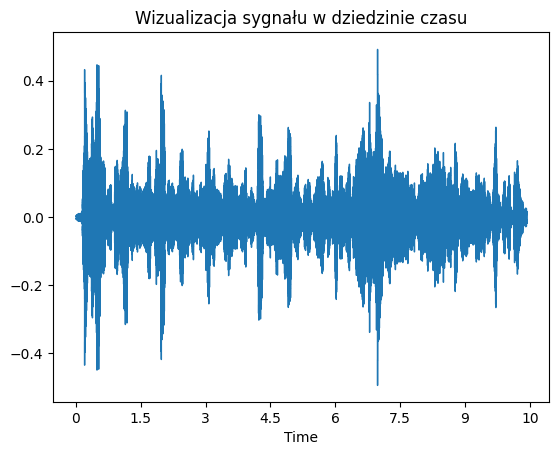

In [38]:
plt.figure(1)
librosa.display.waveshow(data, sr=samplerate)
plt.title('Wizualizacja sygnału w dziedzinie czasu')
plt.show()

Normalizacja sygnału dźwiękowego

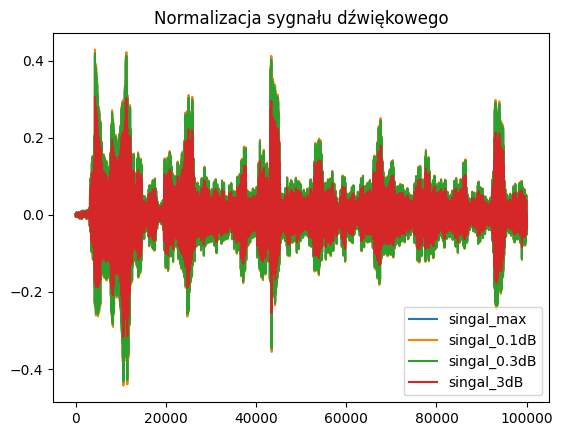

In [39]:
signal_max=np.max(data)

maxx=data/librosa.db_to_amplitude(signal_max)
plt.figure(2)
plt.plot(maxx[:100000], label="singal_max")
signal_0_1= data/librosa.db_to_amplitude(0.1)
plt.plot(signal_0_1[:100000], label="singal_0.1dB")
signal_0_3= data/librosa.db_to_amplitude(0.3)
plt.plot(signal_0_3[:100000], label="singal_0.3dB")
signal_3= data/librosa.db_to_amplitude(3)
plt.plot(signal_3[:100000], label="singal_3dB")
plt.title("Normalizacja sygnału dźwiękowego")
plt.legend()

Spektogram sygnału

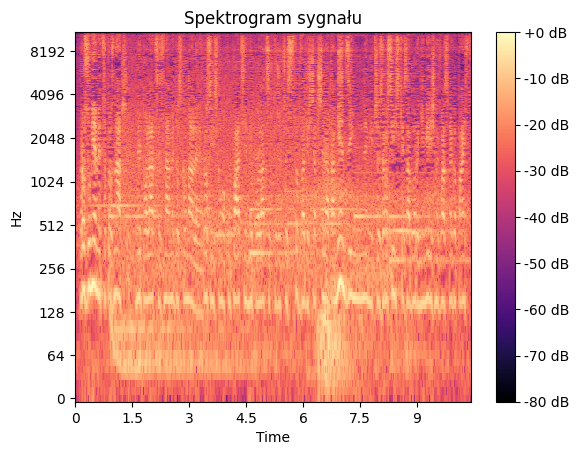

In [98]:
stft= np.abs(librosa.stft(data,n_fft=2048,window=('hann')))
fig, ax = plt.subplots()
spectogram_dB = librosa.power_to_db(stft, ref=np.max)
img = librosa.display.specshow(spectogram_dB, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spektrogram sygnału')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


Utworzenie filtru środkowozaporowego 

In [41]:
def filtr(voice,filter_min,filter_max):
    b, a = signal.butter(2, Wn=(filter_min,filter_max),btype="bandstop", analog=False)
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, voice, zi=zi*voice[0])
    voice, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    return voice


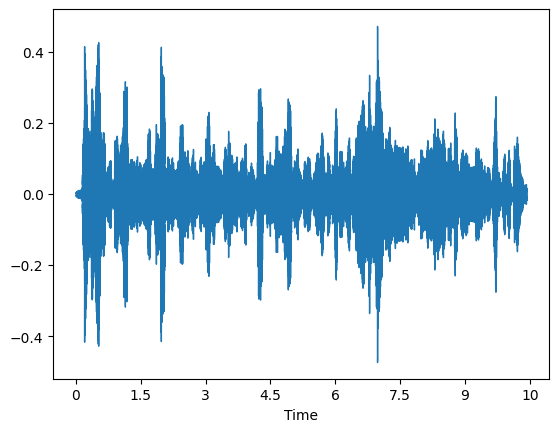

In [42]:
voice =filtr(data,0.3,0.4)
librosa.display.waveshow(voice, sr=samplerate)

Dodania losowych szumów 


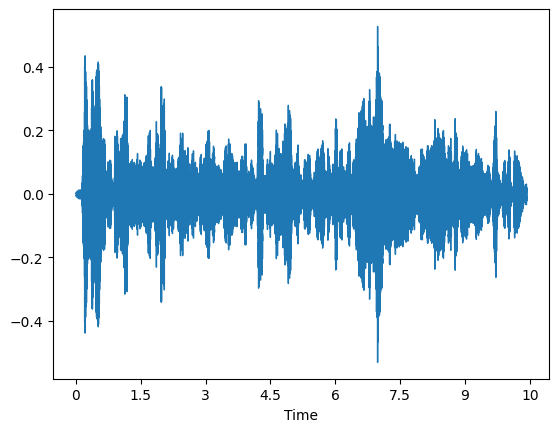

In [43]:
min_noise = 0.01
max_noise = 0.4
noise = np.random.normal(min_noise,max_noise,10)
voice_noise = np.convolve(voice,noise)

librosa.display.waveshow(voice_noise, sr=samplerate)

Przesunięcie tonu sygnału

In [54]:
def pitch_shift(voice,sr,n_steps,bins_per_octave):
    rate =2.0**(-float(n_steps) / bins_per_octave)
    orig_sr = float(sr) / rate 

    ratio = float(sr) / orig_sr 
    y_hat = np.apply_along_axis(
        soxr.resample,
        axis = -1,
        arr = librosa.effects.time_stretch(voice,rate=rate),
        in_rate = orig_sr,
        out_rate = sr,
        quality = "soxr_hq",
    )

    y_shift = np.asarray(y_hat, dtype=voice.dtype)
    return librosa.util.fix_length(y_shift, size=voice.shape[-1])

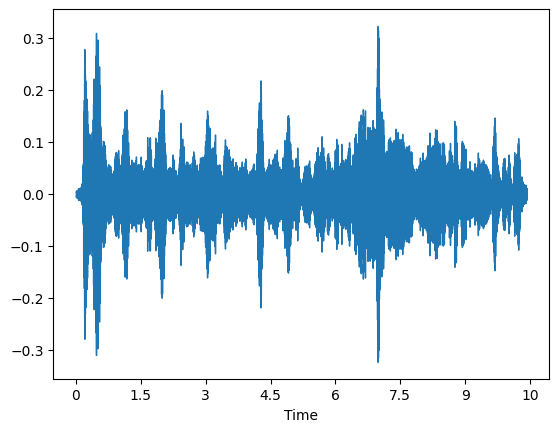

In [55]:
y = pitch_shift(data,samplerate,-3,12)
librosa.display.waveshow(y, sr=samplerate)

Ostateczny kształt filtru 

In [64]:
def ultimate_filter(voice,sr,n_steps,octaves,min_noise,max_noise,filter_min,filter_max):
    voice_shift = pitch_shift(voice,sr,n_steps,octaves)
    noise = np.random.normal(min_noise,max_noise,10)
    voice_noise = np.convolve(voice_shift,noise)
    voice_filter=filtr(voice_noise,filter_min,filter_max)
    return(voice_shift,voice_noise,voice_filter)

In [75]:
voice_shift,voice_noise,voice_ultimate = ultimate_filter(data,sr=samplerate,n_steps=-4,octaves=12,min_noise=0.01,
                                                       max_noise=0.5,filter_min=0.1,filter_max=0.35)

Zapisanie przekształconych głosów

In [76]:
sf.write(f"przemowa_shift.wav",voice_shift,samplerate=samplerate)
sf.write(f"przemowa_noise.wav",voice_noise,samplerate=samplerate)
sf.write(f"przemowa_ultimate_filter.wav",voice_ultimate,samplerate=samplerate)

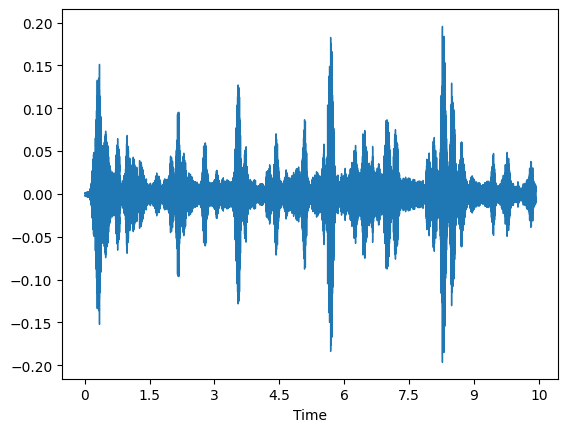

In [77]:
librosa.display.waveshow(voice_ultimate, sr=samplerate)

Widmo w dziedzinie czasu

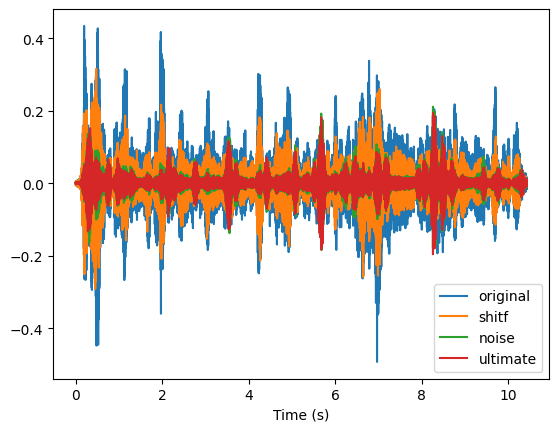

In [93]:
time = np.linspace(0,len(data)/samplerate,num=len(data))
time_noise = np.linspace(0,len(voice_noise)/samplerate,num=len(voice_noise))
time_ultimate = np.linspace(0,len(voice_ultimate)/samplerate,num=len(voice_ultimate))


plt.figure(3)
plt.plot(time,data,label="original")
plt.plot(time,voice_shift,label="shitf")
plt.plot(time_noise,voice_noise,label="noise")
plt.plot(time_ultimate,voice_ultimate,label="ultimate")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

Widmo w dziedzinie częstotliwości 

c:\Users\pawel\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


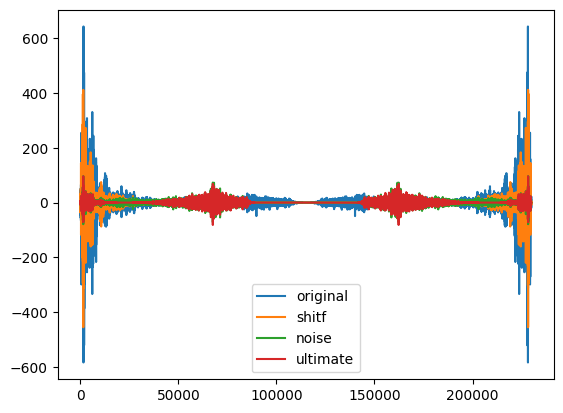

In [94]:
F_data= fftpack.fft(data)
F_shift =fftpack.fft(voice_shift)
F_noise =fftpack.fft(voice_noise)
F_ultimate =fftpack.fft(voice_ultimate)
time = np.linspace(0,len(data)/samplerate,num=len(data))
time_noise = np.linspace(0,len(data)/samplerate,num=len(data))

plt.figure(4)
plt.plot(F_data,label="original")
plt.plot(F_shift,label="shitf")
plt.plot(F_noise,label="noise")
plt.plot(F_ultimate,label="ultimate")
plt.legend()
plt.show()

Spektrogram sygnału po filtracji

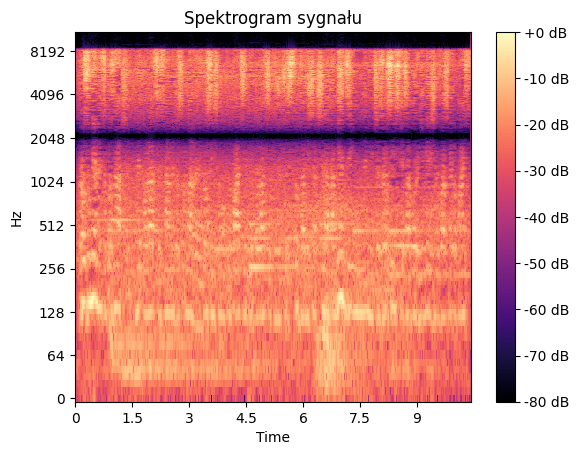

In [97]:
stft= np.abs(librosa.stft(voice_ultimate,n_fft=2048,window=('hann')))
fig, ax = plt.subplots()
spectogram_dB = librosa.power_to_db(stft, ref=np.max)
img = librosa.display.specshow(spectogram_dB, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spektrogram sygnału')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
